In [1]:
import numpy as np
import pandas as pd
import pyreadr
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

from natsort import natsorted
from glob import glob
import pickle
import os
from os.path import basename, splitext
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy.stats import multivariate_normal
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
pd.set_option('display.max_columns', 40)
sns.set_theme(context='notebook', style='ticks')
plt.rcParams['axes.facecolor'] = '#fafafa'
from scipy.stats import pearsonr

from utils.shift import *
from utils.age import *
from utils.vis import (plot_performance_scatter, 
                       plot_repr_uncertainty, 
                       METHYLCLOCK_NAMES_MAPPER)

%load_ext autoreload
%autoreload 2

#aux
clocks = pickle.load(open('subdata/clock_coefs.pkl', 'rb'))

In [3]:
#Aging
p = '/home/shappiron/Desktop/Bio/Antiaging/Dynamics of aging/data/GSE87571/data_joined.csv'
dfa = pd.read_csv(p, index_col=0)
meta = pd.read_csv('/home/shappiron/Desktop/Bio/Antiaging/Dynamics of aging/data/GSE87571/descriptions_samples.csv', 
                   index_col=0)
dfa = dfa[meta.index]
print('Age 1, N sites', len(dfa.index))

#Reprogramming
dfr = pd.read_csv('./data/GSE54848/data.csv', index_col=0)
metr = pd.read_csv('data/GSE54848/meta.csv', index_col=0).loc[dfr.columns]
print('Rep, N sites', len(dfr.index))

Age 1, N sites 450203
Rep, N sites 485577


# 1D demonstration of epistemic uncertainty estimation with Gaussian Process regressor

Dataset dimensionality: (729, 1)
The CpG site used: cg16867657
R2 train = 0.9111736162326212
R2 test = 0.903859403160204
MAE train = 4.905188135516879
MAE test = 4.910198152757776
------------------------------
Resulting kernel: 53.5**2 * RBF(length_scale=0.311) + WhiteKernel(noise_level=40)


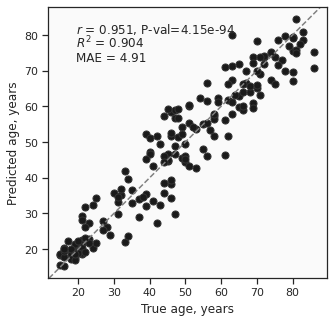

In [8]:
# case with dim X > 1
# clock = clocks['Hannum clock (71 CpGs)']
clock = clocks['Skin clock (391 CpGs)']
sites = clock.index.intersection(dfr.index).intersection(dfa.index)

sites_ = dfa.loc[sites].T.corrwith(meta['age']).sort_values(ascending=False).index[[0]]

Xa_clock = dfa.loc[[sites_[0]]].T
Xr_clock = dfr.loc[[sites_[0]]].T

print("Dataset dimensionality:", Xa_clock.shape)
print("The CpG site used:", sites_[0])

ya = meta['age']
yr = metr['age'].values

X_train, X_test, y_train, y_test = train_test_split(Xa_clock, ya, test_size=0.25, random_state=10)


### TRAINING ###
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

kernel = (1 * RBF(length_scale=1, length_scale_bounds=(1e-2, 100)) + 
          WhiteKernel(noise_level=1, noise_level_bounds=(1e-1, 100))
          )
         
model = GaussianProcessRegressor(kernel=kernel, normalize_y=False, n_restarts_optimizer=3)
model.fit(X_train, y_train)

y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

print(f'R2 train = {r2_score(y_train, y_train_predict)}')
print(f'R2 test = {r2_score(y_test, y_test_predict)}')
print(f'MAE train = {mean_absolute_error(y_train, y_train_predict)}')
print(f'MAE test = {mean_absolute_error(y_test, y_test_predict)}')
print('-'*30)
print("Resulting kernel:", model.kernel_)

plot_performance_scatter(y_test, y_test_predict, eq_bounds=(35, 80), )

We see a good performance of GP model trained with only 1 CpG site.

/home/shappiron/anaconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(


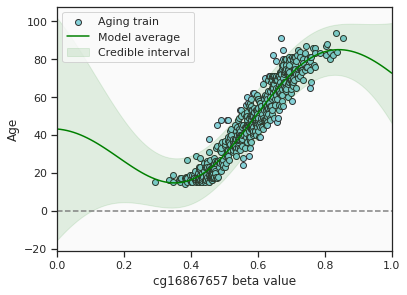

In [46]:
idsort = np.argsort(X_train.iloc[:, 0]).values
x_train = X_train.iloc[idsort, :]
y_train_predict, y_train_std = model.predict(x_train, return_std=True)

x_train2 = np.linspace(0, 1, 100)[:, None]
y_train_predict2, y_train_std2 = model.predict(x_train2, return_std=True)


plt.figure(figsize=(6, 4.5))
plt.scatter(x_train.iloc[:, 0], y_train[idsort], label='Aging train', edgecolors='#333333', color='#86d2da')
plt.plot(x_train2[:, 0], y_train_predict2,color='green', label='Model average')
plt.fill_between(x_train2[:, 0], 
                 y_train_predict2 + 2*y_train_std2, 
                 y_train_predict2 - 2*y_train_std2, 
                 alpha=0.1, color='green', label='Credible interval')

plt.xlim([0, 1.0])
plt.axhline(0, color='grey', ls='--')
plt.ylabel('Age')
plt.xlabel(f'{sites_[0]} beta value')
plt.legend(loc='upper left')
plt.savefig('figs/A4_gp_idea_train.pdf', format='pdf', bbox_inches='tight')
plt.show()

/home/shappiron/anaconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(


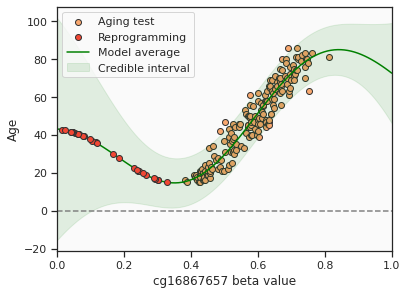

In [47]:
idsort = np.argsort(X_test.iloc[:, 0]).values
x_test = X_test.iloc[idsort, :]
y_test_predict, y_test_std = model.predict(x_test, return_std=True)

x_test2 = np.linspace(0, 1, 100)[:, None]
y_test_predict2, y_test_std2 = model.predict(x_test2, return_std=True)
y_test_predict_r, y_test_std_r = model.predict(Xr_clock, return_std=True)

plt.figure(figsize=(6, 4.5))
plt.scatter(x_test.iloc[:, 0], y_test[idsort], label='Aging test', color='#f9a86f', edgecolors='#333333')

plt.scatter(Xr_clock.iloc[:, 0], y_test_predict_r, color='#f24734', label='Reprogramming', 
            zorder=3, edgecolors='#333333')
plt.plot(x_test2[:, 0], y_test_predict2, color='green', label='Model average')
plt.fill_between(x_test2[:, 0], 
                 y_test_predict2 + 2*y_test_std2, 
                 y_test_predict2 - 2*y_test_std2, 
                 alpha=0.1, color='green', label='Credible interval')


plt.xlim([0, 1.0])
plt.axhline(0, color='grey', ls='--')
plt.ylabel('Age')
plt.xlabel(f'{sites_[0]} beta value')
plt.legend(loc='upper left')
plt.savefig('figs/A4_gp_idea_test.pdf', format='pdf', bbox_inches='tight')
plt.show()